# Part 1

The housing estate is laid out as shown in Figure 1, each house is fed by a single-phase connection. You may assume that the average power profile of the homes follows the Elexon Class 1 curves1, but all scaled to ensure that the a winter peak is 1.25kW.

At the time of the original design, it is known that an ADMD of 2kW was used. The transformer at the substation is rated at 33kV/415 V, 250 kVA, Z=14% pu. The same cable size is used throughout.

The **phase voltage** is the voltage between a phase sub cable (that goes into a house) and ground.

The **line voltage** is the voltage difference between each phase. It's difference between each of the three lines in one cable. Since the phases are at a certain geometric offset, we multiply this by sqrt(3)

![Line Voltage](./lineVoltage.png)

Transformer is creating a three-phase output.

This is why we have: 
$$
V_{phase} = \frac{V_{line}}{\sqrt 3}
$$

$$
V_{phase} = \frac{415 V}{\sqrt 3} = 239.6003617137
$$
We round this to 240 V

## Resistance of the line

For a UK DNO, the voltage drop from a transformer to the end of a line should be max 7%

For minimum voltage at the end of the line:

$$
V_{phase} = 240 V * 0.93
$$

$$
V_{phase} = 223.2 V
$$

We derive $R_{line}$ with the voltage drop from the top to the bottom:

$$
V_{\text{phase, transformer}} - I*R_{\text{Line}} = V_{\text{phase, end of line}}
$$
$$
240V - I*R_{\text{Line}} = 223 V
$$

$$
R_{\text{line}} = \frac{17}{I_{\text{current at the top of the transformer}}}
$$

Power going into each home should be around **56 kW** due to low voltage, residential, and radial design standards. We then use this to derive the current of the cable.

$$
P = IV
$$

$$
I = \frac{P_{\text{Home}}}{V_{\text{Phase}}}
$$

$$
I = \frac{56 kW}{240 V}
$$

$$
I = 233.3333333333 A
$$

Now, let's consider the power going into each house.

We want the power into each house to be $P_{house} = 2kW$
We also want the voltage to be $V_{house} = 240$
With this, we calculate the home's current:

$$
I_{home} = \frac{P_{home}}{V_{home}}
$$

$$
I_{home} = \frac{2000 W}{240 V}
$$

$$
I_{home} = 8.333 A
$$

How do we calculate the overall current?

We want one phase to provide power for three houses at a time.

In one side of a road, we have 24 houses. Therefore, we need 8 buses to supply 24 houses.

Each bus will provide current for three houses. So, each bus will provide $3*I_{home}$ of current. For one road, we have 8 buses that provide a total of $24*I_{home}$

But each bus provides three phases, so to calculate the current in each phase cable, we divide that by three

$$
I_{feeder} = \frac{24 \text{houses} * I_{home}}{3 \text{ phases}}
$$

$$
I_{feeder} = 8 * I_{home}
$$

$$
I_{feeder} = 8 * 8.333 A
$$

$$
I_{feeder} = 66.7 A
$$

With this max amperage, we see that we can use the BS 5467 MAINS CABLE XLPE with the following conditions:
- 1 THREE OR1 FOUR CORE CABLE THREE-PHASE AC : 75 A
- 16 MM^2

(https://www.clevelandcable.com/media/pdfs/BS5467-XLPE-MDPE-fixed-wiring-mains-cable.pdf)

$$ \pi r^2 = 16$$
$$ r = 2.2567583342 mm$$
$$ r = 0.002256758334 m$$
Now, the area in $m^2$

$$ \pi 0.000016^2$$
$$= 0.000016 m^2$$
$$A = 1.6 10^{-5} m^2$$

$$
R = \frac{\rho L}{A}
$$

$$\rho = 1.72 * 10^{-8} \Omega * m, A = 16*10^{-6} m^2$$




In [1]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot

# create an empty network
net = pp.create_empty_network()

#create bus from high voltage 
high_voltage_volts = 33e3 # 33 kV on the high side of the transformer
high_voltage_kv = 33 

low_voltage_volts = 415 # 415 V on the low side of the transformer
low_voltage_kv = 0.415
high_voltage_bus = pp.create_bus(net, vn_kv=high_voltage_kv, name="High Voltage")
low_voltage_bus = pp.create_bus(net, vn_kv=low_voltage_kv, name="Low Voltage")

real_impedance = 1 # assumption given from professor
total_impedance = 14
iron_losses = 0.0075 # 0.5 percent of the rating of the transformer. 0.25 M VA *0.005 here
open_loop_losses = 0.5 # to verify, we used previously apparently

# The transformer at the substation is rated at 
# 33kV/415 V, 250 kVA, Z=14% pu.
# 33kV/0.415 kV, 0.250 MVA, Z=14% pu.


# We chose a transformer here:
# https://pandapower.readthedocs.io/en/v2.13.1/std_types/basic.html#transformers
# transformer = pp.create_transformer(
#   net,
#   hv_bus=high_voltage_bus,
#   lv_bus=low_voltage_bus,
#   std_type="0.25 MVA 20/0.4 kV",
#   name="Main Transformer")

transformer = pp.create_transformer_from_parameters(
  net,
  hv_bus=high_voltage_bus,
  lv_bus=low_voltage_bus,
  sn_mva=1.5, # 0.25 MVA from the assignment prompt
  vn_hv_kv=high_voltage_kv,
  vn_lv_kv=low_voltage_kv,
  vkr_percent=real_impedance,
  vk_percent=total_impedance,
  pfe_kw=iron_losses,
  i0_percent=open_loop_losses,
  shift_degree=0,
  tap_side="hv",
  tap_pos=-3, # lower here, means higher voltage on the other side due to the ratios
  tap_neutral=0,
  tap_max=-5, # 5 percent up and down
  tap_min=5,
  tap_step_percent=1, # one step at a time (given in the question)
  tap_step_degree=0, # we're not doing any phase shifting
  tap_phase_shifter=False,
  name="Main Transformer")

In [2]:
# create the slack bus
slack_voltage_per_unit = 1.00 # we reduced this to 0 since the tap changer is controlling the voltage now
pp.create_ext_grid(net, bus=high_voltage_bus, vm_pu=slack_voltage_per_unit, name="Grid Connection with Slack Bus")

0

Now, let's create the buses for the loads

In [3]:
num_buses_per_line = 8
num_lines = 4

lines = []
for line in range(num_lines):
  buses_for_line = []
  for i in range(num_buses_per_line):
    buses_for_line.append(pp.create_bus(net, vn_kv=low_voltage_kv, name=f"Bus {i+1}"))
  lines.append(buses_for_line[:])
# lines

In [4]:
# Create a bus for each group of three houses
power_per_house_mw = 0.008 # 2 kW ADMD, 1.25 kW actual peak
real_power_load_per_three_houses = 3 * power_per_house_mw
power_factor = 0.9

hypotenuse = real_power_load_per_three_houses / power_factor

# rp^2 + im^2 = h^2
# im = sqrt(h^2 - rp^2)

reactive_power_per_three_houses = (hypotenuse**2 - real_power_load_per_three_houses**2)**0.5
for line in range(num_lines):
  for i in range(num_buses_per_line):
    pp.create_load(net, bus=lines[line][i-1], p_mw=real_power_load_per_three_houses, q_mvar=reactive_power_per_three_houses, name=f"Load for bus {i+1}")

## Calculating capacitance

$$
C = \frac{\Epsilon_{r}}{18 * ln(\frac{D_{out}}{D_{in}})} \mu F / km
$$
Find $D_{in}$ from mm^2 of 35. We add 2 mm of insulation on each side
$$
C = \frac{\Epsilon_{r}}{18 * ln(\frac{D_{out}}{D_{out}+4})} \mu F / km
$$

## Experimenting with cables

In [5]:
# Now create lines between the buses
# For 35 mm^2 (cable for 2 kW ADMD): 1.15, 0.135, 0.59e3, 0.115
# For 16 mm^2 (cable for 1.25 kW ADMD): 2.5, negligible, 0.437e3, 0.075
# For 50 mm^2 (Cable we will use with -3): 0.866, 0.135, 0.34e3, 0.135

cables_to_try = {
  "35mm":{ "r_per_km": 1.15, "x_per_km": 0.135, "c_per_km": 0.59e3, "thermal_i_per_km": 0.115 },  
  "16mm":{ "r_per_km": 2.5, "x_per_km": 0, "c_per_km": 0.437e3, "thermal_i_per_km": 0.075 },
  "50mm":{ "r_per_km": 0.866, "x_per_km": 0.135, "c_per_km": 0.34e3, "thermal_i_per_km": 0.135 },
  "95mm":{ "r_per_km": 0.43, "x_per_km": 0.13, "c_per_km": 0.22e3, "thermal_i_per_km": 0.197 }, #Unsure about how to do the capacitance calculations.
  "120mm":{ "r_per_km": 0.34, "x_per_km": 0.13, "c_per_km": 0.22e3, "thermal_i_per_km": 0.13 },
  "150mm":{ "r_per_km": 0.28, "x_per_km": 0.125, "c_per_km": 0.22e3, "thermal_i_per_km": 0.251 },
  "185mm":{ "r_per_km": 0.22, "x_per_km": 0.125, "c_per_km": 0.22e3, "thermal_i_per_km": 0.281},
  "240mm":{ "r_per_km": 0.175, "x_per_km": 0.125, "c_per_km": 0.22e3, "thermal_i_per_km": 0.324 },
  "300mm":{ "r_per_km": 0.14, "x_per_km": 0.12, "c_per_km": 0.22e3, "thermal_i_per_km": 0.12 }, ##May need to change the thermal_i value to z)
}

cable_of_choice="240mm"

width_of_home_km = 0.012 # 12 meters 
line_resistance_per_km = cables_to_try[cable_of_choice]["r_per_km"] # ohms per km
line_reactance_per_km = cables_to_try[cable_of_choice]["x_per_km"] # 0.135 ohms per km
line_capacitance_per_km = cables_to_try[cable_of_choice]["c_per_km"] # 0.34e3 nano Farads per km
max_thermal_current_kA =  cables_to_try[cable_of_choice]["thermal_i_per_km"] # 0.135 # this is the rating of our cable in kA

for line in range(num_lines):
  for i in range(num_buses_per_line):
    if i == 0:
      pp.create_line_from_parameters(
        net,
        from_bus=low_voltage_bus,
        to_bus=lines[line][i],
        length_km=width_of_home_km*7,
        r_ohm_per_km=line_resistance_per_km,
        x_ohm_per_km=line_reactance_per_km,
        c_nf_per_km=line_capacitance_per_km,
        max_i_ka=max_thermal_current_kA,
        name=f"Line from High Voltage to Bus {i+1}")
    else:
      pp.create_line_from_parameters(
        net,
        from_bus=lines[line][i-1],
        to_bus=lines[line][i],
        length_km=width_of_home_km*3,
        r_ohm_per_km=line_resistance_per_km,
        x_ohm_per_km=line_reactance_per_km,
        c_nf_per_km=line_capacitance_per_km,
        max_i_ka=max_thermal_current_kA,
        name=f"Line from Bus {i} to Bus {i+1}")
# net.line

In [6]:
# net.bus

In [7]:
pp.runpp(net, numba=False)

# Resulting Voltages on Buses

In [8]:
net.res_bus
# We want to max sure that the voltage is -10% to +6% of the nominal voltage 

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-0.807884,-0.481239
1,0.985079,-4.067814,0.000000,0.000000
2,0.961572,-4.295787,0.024000,0.011624
3,0.952730,-4.384178,0.024000,0.011624
4,0.945131,-4.461260,0.024000,0.011624
5,0.938784,-4.526450,0.024000,0.011624
6,0.933697,-4.579240,0.024000,0.011624
7,0.929875,-4.619211,0.024000,0.011624
8,0.927325,-4.646042,0.024000,0.011624
9,0.926049,-4.659513,0.024000,0.011624


No or insufficient geodata available --> Creating artificial coordinates. This may take some time


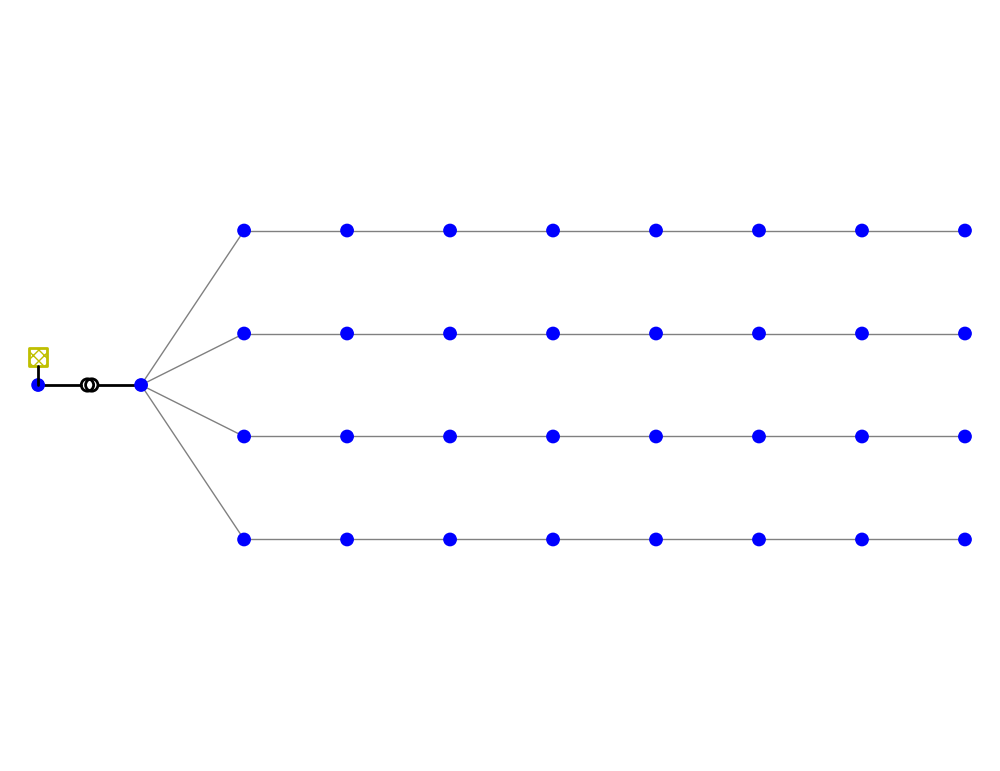

<Axes: >

In [9]:
pp.plotting.simple_plot(net)

In [10]:
net.res_trafo

,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,pl_mw,ql_mvar,i_hv_ka,i_lv_ka,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree,loading_percent
0,0.807884,0.481239,-0.802352,-0.396482,0.005532,0.084757,0.016452,1.263943,1.0,0.0,0.985079,-4.067814,62.690376


In [11]:
cmap_list=[(0, "green"), (50, "yellow"), (100, "red")]
cmap, norm = plot.cmap_continuous(cmap_list)

use_bus_geodata is automatically set to True, since net.line_geodata is empty.


<Axes: >

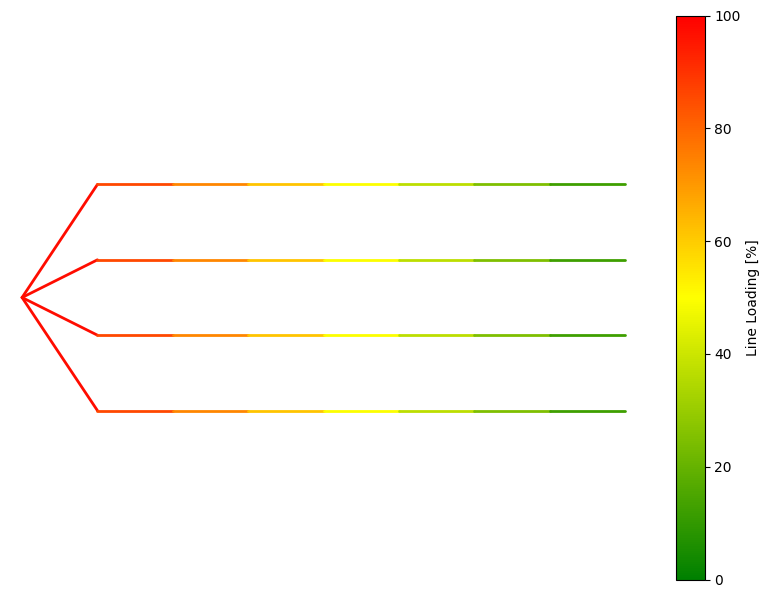

In [12]:
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=2)
plot.draw_collections([lc], figsize=(8,6))

<Axes: >

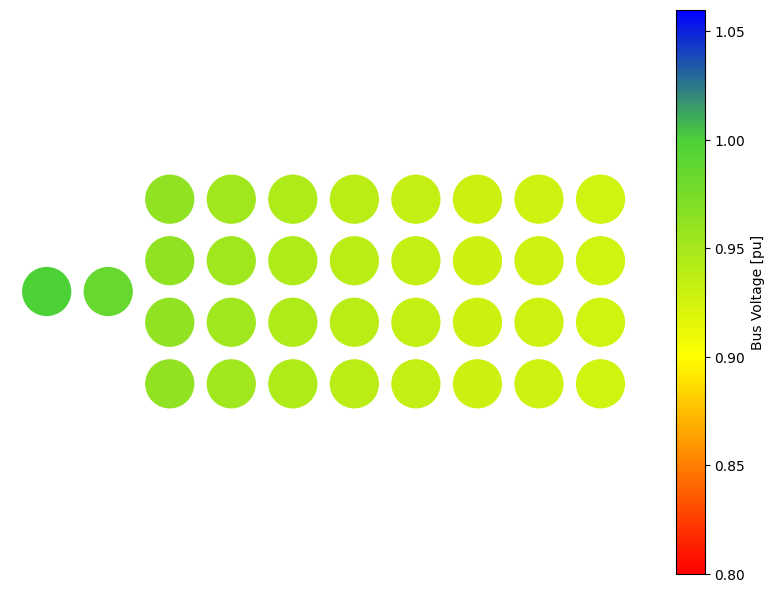

In [13]:
ideal_color = "#4cd137"
too_high_color = "blue"
too_low_color = "yellow"
very_low_color = "red"
cmap_list=[(0.8, very_low_color), (0.9, too_low_color), (1.0, ideal_color), (1.06, too_high_color)] #+6 and -10 percent for voltage regulations
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.4, zorder=2, cmap=cmap, norm=norm)
plot.draw_collections([bc], figsize=(8,6))

<Axes: >

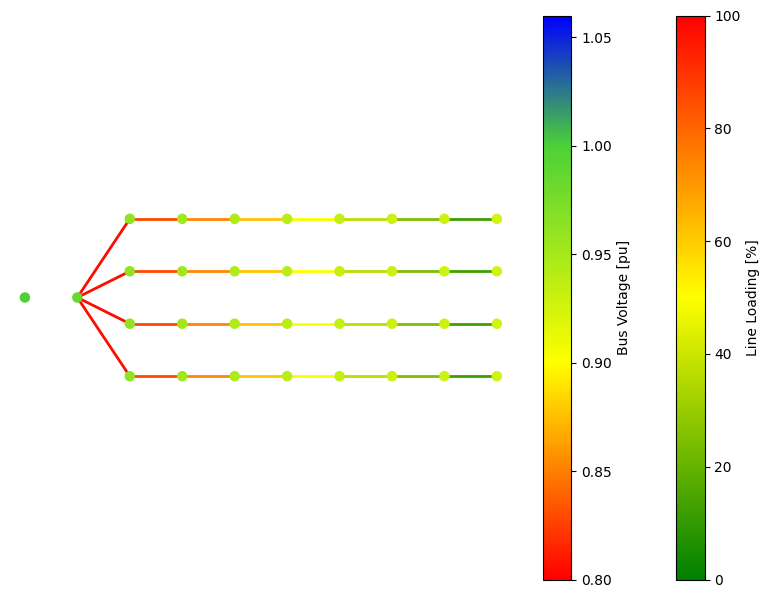

In [14]:
ideal_color = "#4cd137"
too_high_color = "blue"
too_low_color = "red"
cmap_list=[(0.8,"red"),(0.9, "yellow"), (1.0, ideal_color), (1.06, too_high_color)] #+6 and -10 percent for voltage regulations
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap, norm=norm)
plot.draw_collections([lc,bc], figsize=(8,6))

<Axes: >

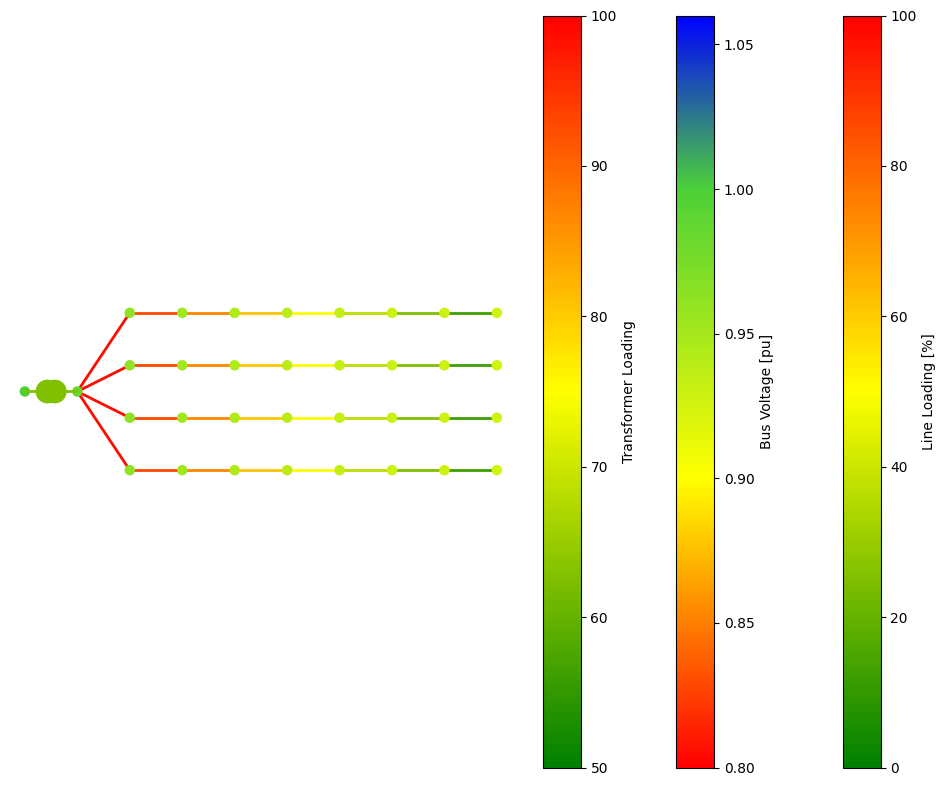

In [15]:
cmap_list=[(50, "green"), (75, "yellow"), (100, "red")]
cmap, norm = plot.cmap_continuous(cmap_list)
tc = pp.plotting.create_trafo_collection(net, net.trafo.index, cmap=cmap, norm=norm)
plot.draw_collections([lc,bc, tc])

In [16]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,0.200588,0.099121,-0.196185,-0.095976,0.004403,0.003144,0.315986,0.315986,0.315986,0.985079,-4.067814,0.961572,-4.295787,97.526688
1,0.172185,0.084353,-0.170730,-0.083314,0.001454,0.001038,0.277405,0.277406,0.277406,0.961572,-4.295787,0.952730,-4.384178,85.619021
2,0.146730,0.071690,-0.145656,-0.070923,0.001075,0.000767,0.238466,0.238467,0.238467,0.952730,-4.384178,0.945131,-4.461260,73.600804
3,0.121656,0.059299,-0.120905,-0.058764,0.000750,0.000535,0.199214,0.199214,0.199214,0.945131,-4.461260,0.938784,-4.526450,61.485929
4,0.096905,0.047140,-0.096423,-0.046796,0.000482,0.000344,0.159697,0.159697,0.159697,0.938784,-4.526450,0.933697,-4.579240,49.289124
5,0.072423,0.035173,-0.072151,-0.034979,0.000272,0.000194,0.119964,0.119964,0.119964,0.933697,-4.579240,0.929875,-4.619211,37.025850
6,0.048151,0.023355,-0.048030,-0.023269,0.000121,0.000086,0.080067,0.080067,0.080067,0.929875,-4.619211,0.927325,-4.646042,24.712175
7,0.024030,0.011645,-0.024000,-0.011624,0.000030,0.000021,0.040061,0.040061,0.040061,0.927325,-4.646042,0.926049,-4.659513,12.364631
8,0.200588,0.099121,-0.196185,-0.095976,0.004403,0.003144,0.315986,0.315986,0.315986,0.985079,-4.067814,0.961572,-4.295787,97.526688
9,0.172185,0.084353,-0.170730,-0.083314,0.001454,0.001038,0.277405,0.277406,0.277406,0.961572,-4.295787,0.952730,-4.384178,85.619021
